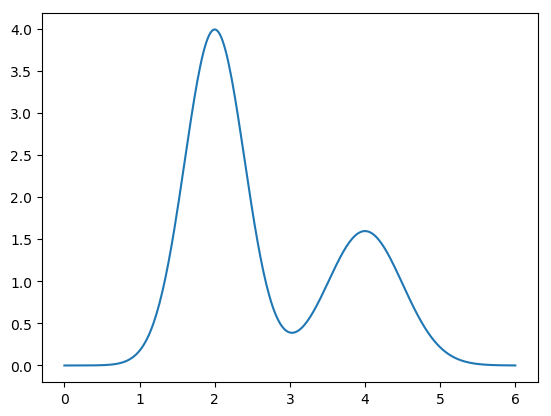

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1a2ae5f98>

In [1]:
using PyCall
include("src/gauss_error.jl")
include("src/kernels.jl")

a = 0.
b = 6.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))

using PyPlot
myplot = plot(x, phi.(x))

In [2]:
kernel_name = "triangular"

function kernel(x::Float64, y::Float64)
    return getOpticsKernels(kernel_name)(x, y)
end

kernel (generic function with 1 method)

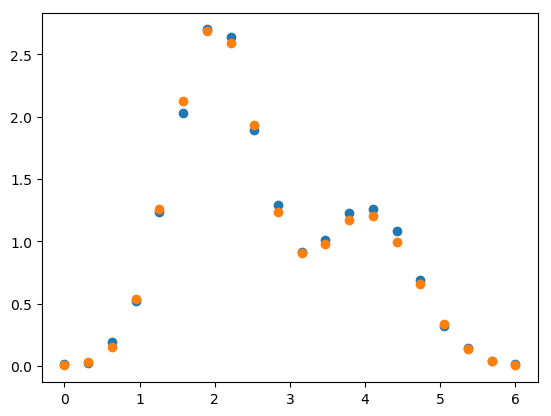

Any[0.00888777, -0.00480116, 0.0396684, -0.00968618, -0.0195524, -0.0988949, 0.00829277, 0.0494844, -0.0445353, 0.0556071, 0.00347363, 0.0317405, 0.0539028, 0.0545216, 0.0870875, 0.0338332, -0.0121158, 0.00790281, 0.00138139, 0.00662381]


In [6]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=20))
ftrue = convolution.(y)
sig = 0.05*ftrue + [0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
plot(y, f, "o")
plot(y, ftrue, "o")
println(noise)

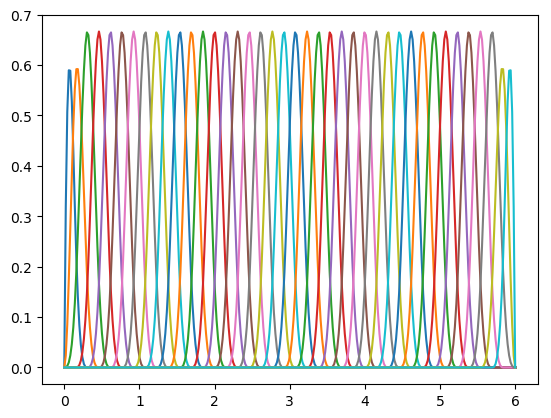

40


In [4]:
knots = collect(range(a, b, length=40))
basis = CubicSplineBasis(knots, ("dirichlet", "dirichlet"))
for basis_function in basis.basis_functions
    plot(x, basis_function.f.(x))
end
println(length(basis))

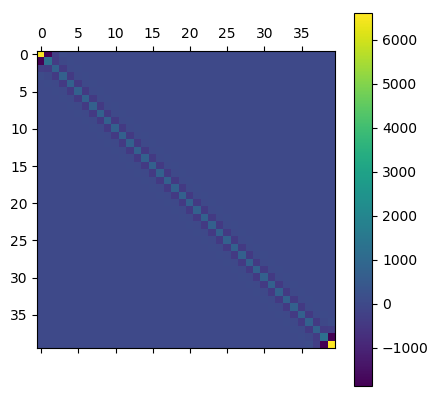

40

PyObject <matplotlib.colorbar.Colorbar object at 0x1a7ee75c0>

In [5]:
print(length(basis))
my_omega = omega(basis, 2)[1]
# for i = 1:size(my_omega)[1]
#     for j = 1:size(my_omega)[1]
#         my_omega[i, j] = abs(my_omega[i, j])
#     end
# end
matshow(my_omega)
colorbar()

In [6]:
model = GaussErrorUnfolder(basis, omega(basis, 2))
println()

starting solve
ending solve
starting solve
ending solve
starting solve_correct
starting optimal_alpha
starting optimize
Iter     Function value   Gradient norm 
     0    -2.872638e+02     1.018390e+01
     1    -2.996935e+02     5.263148e+00
     2    -3.043120e+02     2.738309e-01
     3    -3.043218e+02     3.904826e-04
     4    -3.043218e+02     1.143432e-07
     5    -3.043218e+02     1.306779e-08
     6    -3.043218e+02     6.207201e-08


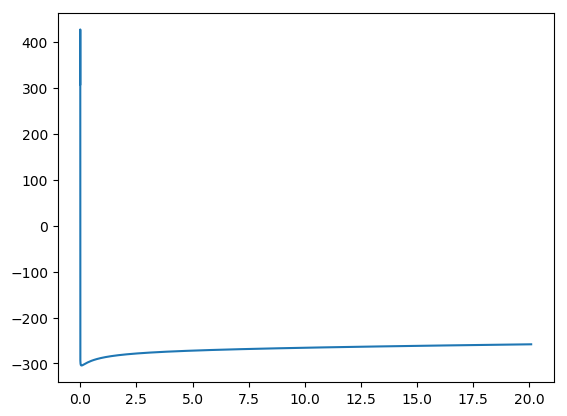

ending solve_correct


Dict{String,Array{Float64,N} where N} with 3 entries:
  "alphas" => [0.0565083]
  "coeff"  => [-0.0155717, -0.0480064, -0.109775, -0.158725, -0.150077, -0.0364…
  "sig"    => [0.00627277 0.0117503 … 2.49859e-6 8.06355e-7; 0.0117503 0.038846…

In [7]:
phi_reconstruct = solve(model, kernel, f, sig, y)

In [8]:
phivec = PhiVec(phi_reconstruct["coeff"], basis, phi_reconstruct["sig"])
println()

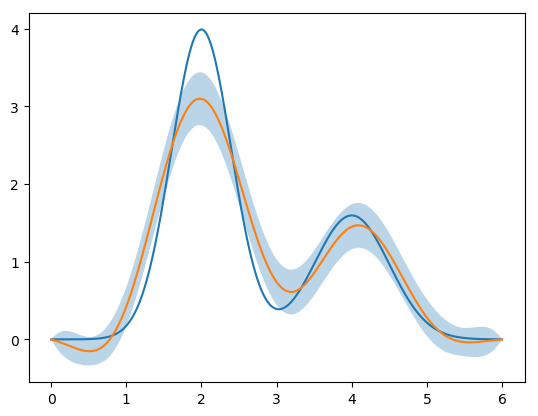

PyObject <matplotlib.collections.PolyCollection object at 0x1952a7f60>

In [9]:
using PyPlot

plot(x, phi.(x))
# title(kernel_name + "kernel")
phi_reconstructed = call(phivec, x)
phi_reconstructed_errors = errors(phivec, x)

plot(x, phi_reconstructed)
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)

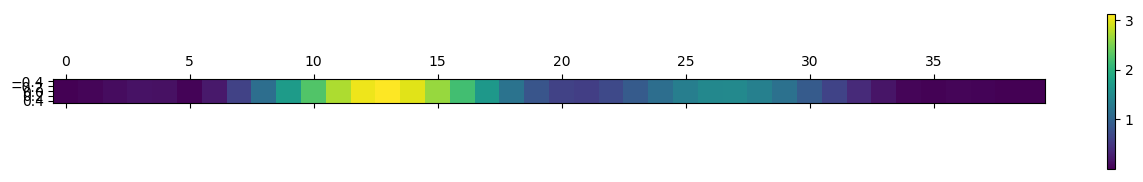

PyObject <matplotlib.colorbar.Colorbar object at 0x1a7e4a1d0>

In [10]:
matshow(reshape(map(x->abs(x), phi_reconstruct["coeff"]), (1, length(basis))))
colorbar()